In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchdiffeq as tdf

import numpy as np

In [3]:
device = torch.device('cuda:' + str(0) if torch.cuda.is_available() else 'cpu')
t = torch.linspace(0., 25., 1000).to(device)
true_A = torch.tensor([[-0.1,2.0], [-2.0, -0.1]]).to(device)
true_y0 = torch.tensor([[2.,0.]]).to(device)
class Lambda(nn.Module):
    def forward(self, t,y):
        return torch.mm(y**3, true_A)

        
with torch.no_grad():
    true_y = tdf.odeint(Lambda(), true_y0, t, method="dopri5")
    
true_y_adjoint = tdf.odeint_adjoint(Lambda(), true_y0, t, method="dopri5")

print(true_y)
print(true_y_adjoint)

tensor([[[ 2.0000,  0.0000]],

        [[ 1.9795,  0.3944]],

        [[ 1.9494,  0.7742]],

        ...,

        [[-0.4418,  0.2882]],

        [[-0.4427,  0.2839]],

        [[-0.4436,  0.2794]]], device='cuda:0')
tensor([[[ 2.0000,  0.0000]],

        [[ 1.9795,  0.3944]],

        [[ 1.9494,  0.7742]],

        ...,

        [[-0.4418,  0.2882]],

        [[-0.4427,  0.2839]],

        [[-0.4436,  0.2794]]], device='cuda:0')


In [121]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(900, dtype=np.int64), 200, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:50]  # ()
    batch_y = torch.stack([true_y[s + i] for i in range(50)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)




In [122]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(2,50),
            nn.Tanh(),
            nn.Linear(50,2),
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
                
    def forward(self, t, y):
        return self.net(y**3)

In [123]:
get_batch()

(tensor([[[-4.3676e-01,  6.2049e-01]],
 
         [[-5.0160e-01,  8.9894e-01]],
 
         [[ 4.6029e-01,  3.8462e-01]],
 
         [[-8.4429e-01, -3.6167e-01]],
 
         [[-8.6701e-01, -4.6480e-02]],
 
         [[-2.3751e-02,  4.8399e-01]],
 
         [[-6.1950e-01, -6.8512e-02]],
 
         [[ 9.1567e-02, -5.6848e-01]],
 
         [[ 6.7086e-01, -6.1326e-01]],
 
         [[-3.6690e-01, -8.0967e-01]],
 
         [[ 7.4499e-01, -2.0198e-01]],
 
         [[-5.2902e-01,  5.6381e-01]],
 
         [[ 3.4186e-01,  6.8357e-01]],
 
         [[-8.8122e-01,  2.8884e-01]],
 
         [[ 4.8213e-01, -4.3738e-01]],
 
         [[-6.1408e-01, -1.6248e-01]],
 
         [[ 3.5791e-01,  6.8223e-01]],
 
         [[ 5.1370e-01,  2.0655e-01]],
 
         [[ 7.2949e-01, -4.6968e-01]],
 
         [[-9.9264e-03,  6.7658e-01]],
 
         [[-1.1366e+00, -7.1162e-01]],
 
         [[ 3.2127e-01,  9.5788e-01]],
 
         [[-1.2240e+00,  2.2360e-01]],
 
         [[-5.7342e-01,  5.1075e-01]],
 
         [[-1.16

In [124]:
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

while True:
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = tdf.odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    if loss < 1e-2:
        break
    print("{}\t loss:\t".format("") + str(loss.item()) )
    optimizer.step()

	 loss:	0.4460955858230591
	 loss:	0.33933794498443604
	 loss:	0.3096700608730316
	 loss:	0.36310267448425293
	 loss:	0.346074640750885
	 loss:	0.3179209530353546
	 loss:	0.33818313479423523
	 loss:	0.3200633227825165
	 loss:	0.2686512768268585
	 loss:	0.2954532504081726
	 loss:	0.3383857309818268
	 loss:	0.29305699467658997
	 loss:	0.30334150791168213
	 loss:	0.3204505145549774
	 loss:	0.2972804009914398
	 loss:	0.27550897002220154
	 loss:	0.2456737458705902
	 loss:	0.27742695808410645
	 loss:	0.2834956645965576
	 loss:	0.2813992202281952
	 loss:	0.27674686908721924
	 loss:	0.3053618371486664
	 loss:	0.26833853125572205
	 loss:	0.2202834188938141
	 loss:	0.2772252857685089
	 loss:	0.2622494697570801
	 loss:	0.2457793951034546
	 loss:	0.23968161642551422
	 loss:	0.24111033976078033
	 loss:	0.23882699012756348
	 loss:	0.21375727653503418
	 loss:	0.23537562787532806
	 loss:	0.22299045324325562
	 loss:	0.20015297830104828
	 loss:	0.1852380335330963
	 loss:	0.2051324099302292
	 loss:	0.198

In [ ]:
import matplotlib.pyplot as plt

In [138]:
t = torch.linspace(0., 50., 1000).to(device)
y_pred = tdf.odeint(func, true_y0, t).to(device)
y_true = tdf.odeint(Lambda(), true_y0, t).to(device)

In [139]:
y_pred.cpu()

tensor([[[2.0000, 0.0000]],

        [[1.9918, 0.4663]],

        [[1.9687, 0.9283]],

        ...,

        [[0.3072, 0.0914]],

        [[0.3069, 0.0946]],

        [[0.3066, 0.0977]]], grad_fn=<ToCopyBackward0>)

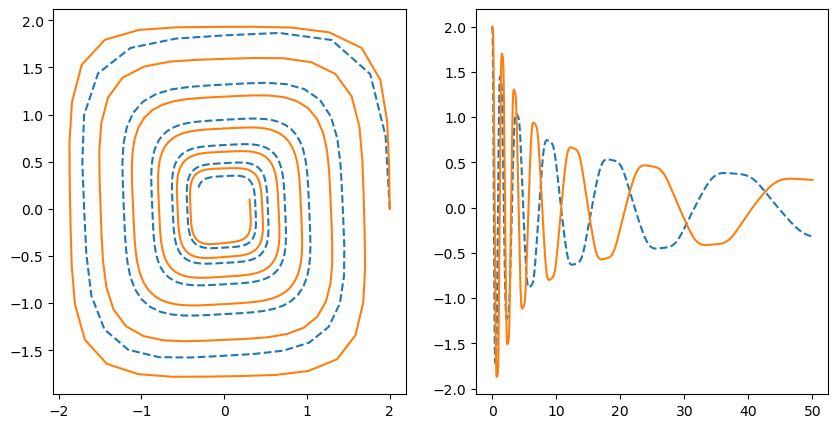

In [141]:

f = plt.figure(figsize=(10,5))
ax = f.add_subplot(121)
ax.plot(torch.Tensor([i[0][0] for i in y_true.cpu()]), torch.Tensor([i[0][1] for i in y_true.cpu()]), linestyle='--')
ax.plot(torch.Tensor([i[0][0] for i in y_pred.cpu()]), torch.Tensor([i[0][1] for i in y_pred.cpu()]))
ax2 = f.add_subplot(122)
ax2.plot(t.cpu(), torch.Tensor([i[0][0] for i in y_true.cpu()]), linestyle='--')
ax2.plot(t.cpu(), torch.Tensor([i[0][0] for i in y_pred.cpu()]))
# plt.plot(torch.Tensor([i[0][0] for i in true_y]),  torch.Tensor([i[0][1] for i in true_y]))
# plt.plot()

In [63]:
t.cpu().numpy()

array([ 0.        ,  0.02502503,  0.05005005,  0.07507508,  0.1001001 ,
        0.12512513,  0.15015015,  0.17517518,  0.2002002 ,  0.22522523,
        0.25025025,  0.2752753 ,  0.3003003 ,  0.3253253 ,  0.35035035,
        0.3753754 ,  0.4004004 ,  0.4254254 ,  0.45045045,  0.4754755 ,
        0.5005005 ,  0.5255255 ,  0.5505506 ,  0.5755756 ,  0.6006006 ,
        0.6256256 ,  0.6506506 ,  0.6756757 ,  0.7007007 ,  0.7257257 ,
        0.7507508 ,  0.7757758 ,  0.8008008 ,  0.8258258 ,  0.8508508 ,
        0.8758759 ,  0.9009009 ,  0.9259259 ,  0.950951  ,  0.975976  ,
        1.001001  ,  1.026026  ,  1.051051  ,  1.076076  ,  1.1011012 ,
        1.1261262 ,  1.1511512 ,  1.1761762 ,  1.2012012 ,  1.2262262 ,
        1.2512512 ,  1.2762762 ,  1.3013012 ,  1.3263264 ,  1.3513514 ,
        1.3763764 ,  1.4014014 ,  1.4264264 ,  1.4514514 ,  1.4764764 ,
        1.5015016 ,  1.5265266 ,  1.5515516 ,  1.5765766 ,  1.6016016 ,
        1.6266266 ,  1.6516516 ,  1.6766766 ,  1.7017016 ,  1.72

In [13]:
all[0][0][1]

tensor(0., grad_fn=<SelectBackward0>)

In [14]:
len(all)

1000